In [1]:
import os,sys
sys.path.append('../src/python/')

import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing._encoders import _BaseEncoder
from sklearn.svm import LinearSVC, SVC

from skl2onnx.sklapi import CastTransformer
from models.onnxlib import ONNXConverter, ONNXPredictorCLF, ONNXPredictorREGR

# Generating the dataset:

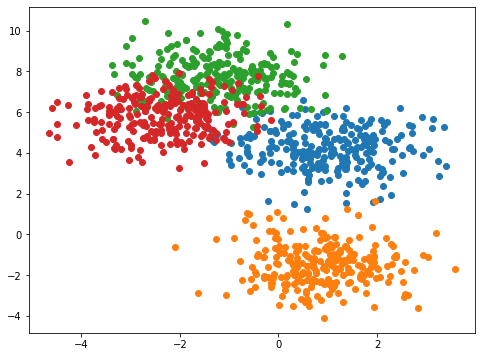

In [2]:
n_samples = 1000

X, y = make_blobs(n_samples=n_samples, centers=4, n_features=3,
                  random_state=0)
plt.figure(figsize=(8, 6))
for y_val in np.unique(y):
    plt.scatter(X[np.where(y == y_val)[0], 0], X[np.where(y == y_val)[0], 1])
plt.show()

In [3]:
# Generating dataset:
weekdays_names = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN', 'none']
data = {'id': np.arange(0, n_samples, 1),
        'num_col1': X[:, 0]*5,
        'num_col2': X[:, 1]*np.random.randint(1, 50) + np.random.randint(1, 100),
        'num_col3': X[:, 2]*np.random.randint(1, 500) + np.random.randint(1, 100),
        'num_col4': np.random.random(n_samples),
        'num_col5': np.random.random(n_samples),
        'cat_col1': np.random.choice(['a', 'b', 'c', 'd', 'e'], n_samples),
        'cat_col2': np.random.choice(['a', 'b', 'c', 'd', 'e'], n_samples),
        'cat_col3': np.random.choice(['a', 'b', 'c', 'd', 'e'], n_samples),
        'bool_col': np.random.choice([0, 1], n_samples),
        'bool_col_nan': np.random.choice([-1, 0, 1], n_samples),
        'class': y}

data = pd.DataFrame(data)
data

,id,num_col1,num_col2,num_col3,num_col4,num_col5,cat_col1,cat_col2,cat_col3,bool_col,bool_col_nan,class
0,0,-8.243023,236.072935,5093.669196,0.992618,0.304503,c,d,b,0,1,2
1,1,-3.196467,231.784437,4641.409281,0.842749,0.089611,a,a,e,1,-1,2
2,2,-15.253717,172.742370,66.282915,0.743012,0.759509,d,a,a,0,1,3
3,3,-7.962813,263.993728,370.306872,0.785052,0.756325,c,b,b,0,0,3
4,4,-5.002747,252.418505,4314.486482,0.925265,0.540551,d,e,d,0,-1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,-3.750063,168.323685,852.782833,0.900822,0.133082,e,d,b,1,-1,0
996,996,-12.017042,228.242507,-217.729960,0.030799,0.162799,b,c,b,0,0,3
997,997,-8.920852,304.584321,4565.311718,0.580023,0.805993,a,d,a,1,1,2
998,998,-9.172772,253.478822,296.278062,0.411792,0.750313,c,b,d,0,1,3


In [4]:
data.dtypes

id                int32
num_col1        float64
num_col2        float64
num_col3        float64
num_col4        float64
num_col5        float64
cat_col1         object
cat_col2         object
cat_col3         object
bool_col          int32
bool_col_nan      int32
class             int32
dtype: object

# Data preparation:

In [5]:
TARGET_COL = 'class'
TARGET_NAMES = [0, 1, 2, 3]

In [6]:
X = data.drop(columns=[TARGET_COL])
y = data[TARGET_COL]

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
print('Train:', x_train.shape[0], 'samples', x_train.shape[1], 'columns')
print('Test:', x_test.shape[0], 'samples', x_test.shape[1], 'columns')

Train: 700 samples 11 columns
Test: 300 samples 11 columns


# Pre-processing Pipeline:

In [9]:
# Creating the transformation:
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [10]:
# Feature Encoding:
numeric_features = ['num_col1', 'num_col2', 'num_col3']
categorical_features  = ['cat_col1', 'cat_col2', 'cat_col3']
passthrough_features = ['num_col5']
all_features_ = (numeric_features + categorical_features
                 + passthrough_features)

features_encoder = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                                   ('cat', categorical_transformer, categorical_features),
                                                   ('passthrough', 'passthrough', passthrough_features)],
                                     remainder='drop')

In [11]:
# Feature Construction:
features_creator = PolynomialFeatures(2, include_bias=False)

In [12]:
# Feature Selection:
clf_select = LinearSVC(C=0.01, penalty="l1", dual=False)
features_selector = SelectFromModel(clf_select)

In [13]:
preprocessor = Pipeline([('feature_encoding', features_encoder),
                         ('feature_creation', features_creator),
                         ('feature_selection', features_selector),
                        ])

In [14]:
# Columns dropped by preprocessor:
columns_to_drop = data.columns[~np.isin(data.columns, all_features_)]
columns_to_drop

Index(['id', 'num_col4', 'bool_col', 'bool_col_nan', 'class'], dtype='object')

In [15]:
x_train_transf = preprocessor.fit_transform(x_train, y_train)
pd.DataFrame(x_train_transf)

,0,1,2,3
0,0.941796,0.185873,0.376664,0.141875
1,0.875312,0.187002,0.395682,0.156564
2,0.847588,0.586090,0.354008,0.125322
3,0.440458,0.944167,0.854743,0.730586
4,0.651551,0.527412,0.298542,0.089127
...,...,...,...,...
695,0.563601,0.107301,0.418975,0.175540
696,0.695781,0.208513,0.389604,0.151791
697,0.864810,0.514341,0.273436,0.074767
698,0.616381,0.857622,0.806448,0.650358


In [16]:
x_encoded_test = pd.DataFrame(preprocessor.transform(x_test))
x_encoded_test

,0,1,2,3
0,0.323766,0.671981,0.170747,0.029155
1,0.492940,0.309169,0.242535,0.058823
2,0.646890,0.624794,0.084819,0.007194
3,0.692036,0.555997,0.230536,0.053147
4,0.553310,0.271483,0.290004,0.084103
...,...,...,...,...
295,0.635558,0.033486,0.319061,0.101800
296,0.489025,0.903532,0.820415,0.673080
297,0.220623,0.678677,0.252791,0.063903
298,0.541163,0.853789,0.747910,0.559370


# Training the model into the main pipeline:

In [17]:
# Creating the clf model:

# RandomForestClassifier:
parameters = {'n_estimators'      : range(1, 100),
              'criterion'         : ['gini', 'entropy'],
              'max_features'      : ['auto', 'sqrt', 'log2'],
              'class_weight'      : ['balanced', 'balanced_subsample', None],
              'min_samples_split' : range(1, 3),
              'min_samples_leaf'  : range(1, 3),
              'max_depth'    : range(1, 10)}

# clf = GridSearchCV(RandomForestClassifier(), parameters, n_jobs=-1)
clf = RandomizedSearchCV(RandomForestClassifier(), parameters, n_iter=50, n_jobs=-1)

In [18]:
# Training the model and getting the results:
clf.fit(x_train_transf, y_train)
clf_results = pd.DataFrame(clf.cv_results_).dropna(subset=['mean_test_score'])
clf_results.head()

c:\users\weldl\miniconda3\envs\embedded-ml\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.98       0.98142857 0.97857143        nan 0.97857143 0.96571429
 0.75714286 0.98142857        nan 0.98285714        nan        nan
        nan 0.97428571 0.97714286        nan        nan 0.97714286
        nan        nan        nan 0.97428571 0.98142857        nan
 0.97857143        nan 0.97857143        nan        nan 0.76
        nan 0.75142857        nan        nan 0.97857143 0.97142857
 0.98285714        nan        nan 0.94428571        nan 0.97857143
        nan 0.97571429 0.97142857        nan 0.97285714 0.97428571
        nan 0.98142857]
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.180439,0.003128,0.012966,6.306756e-04,83,2,1,auto,8,gini,balanced,"{'n_estimators': 83, 'min_samples_split': 2, '...",0.978571,0.978571,0.985714,0.971429,0.985714,0.980000,0.005345,7
1,0.151612,0.003763,0.011768,1.465928e-03,70,2,1,sqrt,9,gini,balanced,"{'n_estimators': 70, 'min_samples_split': 2, '...",0.971429,0.978571,0.992857,0.978571,0.985714,0.981429,0.007284,3
2,0.059745,0.002290,0.003989,3.015783e-07,24,2,1,sqrt,4,entropy,None,"{'n_estimators': 24, 'min_samples_split': 2, '...",0.971429,0.978571,0.985714,0.978571,0.978571,0.978571,0.004518,8
4,0.270885,0.017934,0.014862,1.623339e-03,88,2,1,sqrt,4,entropy,balanced_subsample,"{'n_estimators': 88, 'min_samples_split': 2, '...",0.971429,0.971429,0.985714,0.978571,0.985714,0.978571,0.006389,8
5,0.114402,0.008425,0.007579,4.889476e-04,47,2,2,log2,2,entropy,None,"{'n_estimators': 47, 'min_samples_split': 2, '...",0.964286,0.950000,0.971429,0.964286,0.978571,0.965714,0.009476,23


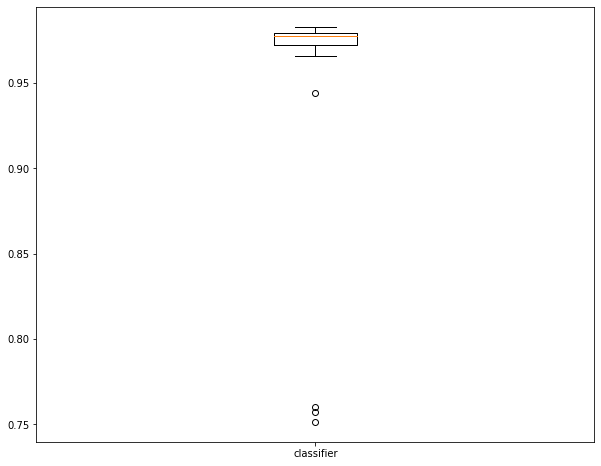

In [19]:
# Models performance:
plt.figure(figsize=(10, 8))
plt.boxplot([clf_results['mean_test_score']])
plt.xticks([1], ['classifier'])
plt.show()

In [20]:
clf.best_estimator_

RandomForestClassifier(max_depth=8, max_features='log2', min_samples_leaf=2,
                       n_estimators=65)

In [21]:
model_full = Pipeline(steps=[('preprocessor', preprocessor),
                             ('estimator', clf.best_estimator_)])

In [22]:
y_pred = model_full.predict(x_test)
y_pred_probs = model_full.predict_proba(x_test)

In [23]:
results = pd.DataFrame(y_pred_probs, columns=clf.best_estimator_.classes_)
results['y_hat'] = y_pred
results.head(10)

,0,1,2,3,y_hat
0,0.000000,0.000000,0.0,1.000000,3
1,0.029060,0.953846,0.0,0.017094,1
2,0.703077,0.010256,0.0,0.286667,0
3,1.000000,0.000000,0.0,0.000000,0
4,0.000000,1.000000,0.0,0.000000,1
5,0.023077,0.000000,0.0,0.976923,3
6,0.471161,0.000000,0.0,0.528839,3
7,0.000000,1.000000,0.0,0.000000,1
8,0.032051,0.000000,0.0,0.967949,3
9,0.558718,0.007692,0.0,0.433590,0


# Model evaluation:

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        77
           1       1.00      1.00      1.00        76
           2       1.00      1.00      1.00        60
           3       1.00      0.99      0.99        87

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



# Converting to ONNX format

In [25]:
onnx_conv = ONNXConverter(preprocessor, clf.best_estimator_)

In [26]:
onnx_conv.convert_initial_types(x_train, y_train, columns_to_drop, show_types=True)


Initial types preprocessing (7):
num_col1 FloatTensorType(shape=[None, 1])
num_col2 FloatTensorType(shape=[None, 1])
num_col3 FloatTensorType(shape=[None, 1])
num_col5 FloatTensorType(shape=[None, 1])
cat_col1 StringTensorType(shape=[None, 1])
cat_col2 StringTensorType(shape=[None, 1])
cat_col3 StringTensorType(shape=[None, 1])

Initial types estimator (1):
x_values FloatTensorType(shape=[None, 4])


In [27]:
prep_filename = './preprocessor_v0.onnx'
estimator_filename = './model_v0.onnx'

onnx_conv.dump_models(prep_filename=prep_filename,estimator_filename=estimator_filename)

./preprocessor_v0.onnx saved successfully.
./model_v0.onnx saved successfully.


# Loading the ONNX files and performing predictions:

In [28]:
onnx_pred = ONNXPredictorCLF(prep_filename, estimator_filename)
onnx_pred.run_predictions(x_test)

array([3, 1, 0, 0, 1, 3, 3, 1, 3, 0, 0, 3, 3, 2, 3, 0, 2, 1, 3, 3, 0, 2,
       1, 0, 1, 3, 2, 3, 0, 2, 0, 0, 3, 0, 1, 3, 3, 0, 1, 3, 1, 1, 3, 0,
       2, 1, 3, 0, 1, 0, 0, 2, 1, 1, 2, 3, 2, 1, 3, 3, 3, 1, 1, 0, 3, 3,
       3, 1, 2, 0, 0, 0, 3, 0, 0, 0, 0, 3, 1, 0, 3, 1, 3, 0, 1, 2, 3, 3,
       3, 3, 2, 1, 3, 0, 1, 1, 3, 3, 0, 1, 0, 2, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 2, 2, 3, 2, 0, 0, 0, 1, 3, 1, 1, 2, 0, 3, 2, 2, 3, 0, 2, 2, 0,
       3, 0, 1, 3, 3, 1, 3, 2, 0, 3, 3, 2, 1, 2, 2, 3, 0, 3, 2, 2, 2, 0,
       2, 3, 0, 0, 1, 0, 0, 1, 1, 1, 0, 3, 1, 3, 2, 1, 3, 2, 0, 3, 3, 3,
       1, 1, 1, 3, 1, 3, 3, 3, 1, 1, 1, 3, 2, 1, 2, 3, 2, 1, 2, 0, 3, 0,
       0, 1, 2, 1, 1, 1, 3, 1, 3, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 3, 2, 3,
       1, 0, 2, 3, 1, 3, 0, 3, 1, 3, 3, 3, 2, 0, 2, 1, 1, 2, 0, 1, 3, 2,
       0, 2, 0, 0, 3, 3, 0, 2, 0, 3, 0, 3, 0, 3, 0, 0, 2, 0, 3, 2, 0, 0,
       2, 0, 3, 1, 1, 2, 2, 2, 1, 0, 2, 2, 3, 1, 2, 1, 0, 1, 1, 1, 3, 3,
       1, 2, 3, 3, 2, 3, 2, 1, 1, 1, 2, 3, 2, 1], d

In [29]:
results_onx = pd.DataFrame(onnx_pred.output_probability)
results_onx['y_hat'] = onnx_pred.output_label
results_onx.head(10)

,0,1,2,3,y_hat
0,0.000000,0.000000,0.0,1.000000,3
1,0.029060,0.953846,0.0,0.017094,1
2,0.703077,0.010256,0.0,0.286667,0
3,1.000000,0.000000,0.0,0.000000,0
4,0.000000,1.000000,0.0,0.000000,1
5,0.023077,0.000000,0.0,0.976923,3
6,0.471161,0.000000,0.0,0.528839,3
7,0.000000,1.000000,0.0,0.000000,1
8,0.032051,0.000000,0.0,0.967949,3
9,0.558718,0.007692,0.0,0.433590,0


In [30]:
print(sum(results['y_hat'] == results_onx['y_hat']), 'equal results')
print(sum(results['y_hat'] != results_onx['y_hat']), 'different results')

300 equal results
0 different results


In [31]:
prob_diffs = results.loc[:, TARGET_NAMES] - results_onx.loc[:, TARGET_NAMES]
prob_diffs

,0,1,2,3
0,0.000000e+00,0.000000e+00,0.0,0.000000e+00
1,-1.305444e-10,-6.235563e-08,0.0,-8.437623e-10
2,-3.557939e-08,-3.199929e-10,0.0,-2.463659e-08
3,0.000000e+00,0.000000e+00,0.0,0.000000e+00
4,0.000000e+00,0.000000e+00,0.0,0.000000e+00
...,...,...,...,...
295,0.000000e+00,0.000000e+00,0.0,0.000000e+00
296,0.000000e+00,0.000000e+00,0.0,0.000000e+00
297,-9.743067e-10,0.000000e+00,0.0,-2.750984e-09
298,0.000000e+00,0.000000e+00,0.0,0.000000e+00


In [32]:
prob_diffs.abs().mean()

0    4.714218e-09
1    7.688593e-10
2    0.000000e+00
3    3.462219e-09
dtype: float64

In [33]:
prob_diffs.abs().max()

0    8.277404e-08
1    6.235563e-08
2    0.000000e+00
3    8.172759e-08
dtype: float64

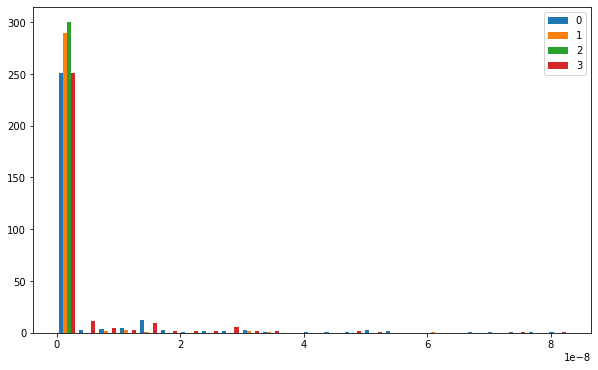

In [34]:
plt.figure(figsize=(10, 6))
plt.hist(prob_diffs.abs(), bins=25, label=prob_diffs.columns)
plt.legend()
plt.show()

In [35]:
# Deleting all files created:
os.remove(onnx_pred.prep_filename)
os.remove(onnx_pred.estimator_filename)